# Расчёт антиоксидантной активности и константы равновесия кинетическим методом

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

Загрузим исходные данные в датафрейм data, а также создадим датафрейм для хранения расчитанных значений

In [2]:
file_name = 'data/exampl.csv'
data = pd.read_csv(file_name, sep=';')
data_output = pd.DataFrame(data=[], columns=['name', 'conc', 'AH0', 'K', 'k'])

Посмотрим данные

In [3]:
data.head(10)

,name,conc,0 min,1 min,2 min,3 min,4 min,5 min,6 min,7 min,...,30 min,31 min,32 min,33 min,34 min,35 min,36 min,37 min,38 min,39 min
0,H2O,0,1.544,1.536,1.524,1.528,1.517,1.521,1.519,1.510,...,1.460,1.451,1.454,1.446,1.450,1.451,1.445,1.431,1.446,1.432
1,H2O,0,1.512,1.508,1.497,1.512,1.498,1.490,1.505,1.491,...,1.444,1.445,1.439,1.433,1.436,1.440,1.427,1.429,1.428,1.419
2,H2O,0,1.506,1.501,1.489,1.500,1.497,1.492,1.496,1.483,...,1.442,1.442,1.436,1.442,1.440,1.438,1.434,1.439,1.433,1.428
3,H2O,0,1.542,1.531,1.532,1.544,1.529,1.530,1.537,1.525,...,1.471,1.474,1.472,1.464,1.473,1.462,1.456,1.459,1.453,1.450
4,Trolox,35,1.470,1.463,1.458,1.472,1.460,1.472,1.473,1.459,...,1.416,1.408,1.415,1.403,1.409,1.410,1.407,1.396,1.400,1.392
5,Trolox,35,1.476,1.475,1.464,1.470,1.459,1.460,1.461,1.457,...,1.408,1.402,1.399,1.395,1.403,1.402,1.391,1.393,1.393,1.389
6,Trolox,35,1.503,1.491,1.481,1.483,1.484,1.485,1.485,1.478,...,1.435,1.425,1.422,1.426,1.421,1.419,1.412,1.418,1.410,1.408
7,Trolox,35,1.468,1.462,1.458,1.466,1.460,1.461,1.455,1.452,...,1.415,1.413,1.412,1.413,1.411,1.408,1.403,1.407,1.402,1.401
8,Trolox,54,1.452,1.445,1.440,1.451,1.455,1.448,1.453,1.446,...,1.393,1.388,1.385,1.384,1.383,1.380,1.378,1.374,1.370,1.373
9,Trolox,54,1.448,1.443,1.434,1.436,1.431,1.431,1.431,1.428,...,1.385,1.385,1.383,1.378,1.375,1.379,1.371,1.367,1.371,1.363


концентрация абтс-радикала в растворе примерно равна 43 мкмоль/л, делим на оптическую плотность, чтобы найти коэф экстинции и рассчитать потерю абтс-радикала далее

In [4]:
# тут последовательно:
#1. Выбираем данные где только H2O. 
#2. Группируем по концентрации с высчитыванием средней
#3. Транспонируем таблицу для удобства использования
#4. Сбрасываем индекс
blank = data.loc[data['name'] == 'H2O'].groupby('conc').mean().T.reset_index(drop=True)

# добавляем время, данные у нас с интервалом в 1 минуту
blank['time'] = [i for i in range(1,41)]

# находим коэффциент экстинции абтс-радикала из начальной точки
abts = 43/blank.loc[0, 0]

Уравнение, описывающее поведение кривых:
\begin{equation*}
\Delta = \frac{AH_0 * R^0}{R^0+K}(1-e^{-k_+[ABTS^{*+}](1+\frac{K}{R^0})*t})
\end{equation*}
где 
$AH_0$ - изначальная концентрация атниоксиданта ,
$R_0$ - изначальное соотношение $\frac{[ABTS*+]}{[ABTS]}$ ,
$K$ - константа равновесия ,
$k_+$ - константа скорости псевдопервого порядка

В наших условиях $R_0 = \frac{[ABTS*+]}{[ABTS]} = 2.5$ , а уровнение выше выведено с допущением, что в ходе протекания
реакции изменением концентраций ABTS* + и ABTS можно пренебречь, поэтому возьмём значение $[ABTS^{*+}]$ = 43 мкМ, для изначального раствора и внесём его в константу $k_+$, туда же для удобства спряем множитель 60, который возникает при переводе данных из минуты в секунды.

Создадим функцию для расчёта

In [5]:
def func(t, AH0, K, k):
    return (AH0*2.5)/(2.5+K)*(1 - np.exp(- k*(1 + K/2.5)*t))

функция для подбора коэффициентов в вышенаписанной функции, а также для постройки графиков по этим коэффициентам
Превые 10 точек выкидываем зи рассмотрения, иначе кривая плохо описывается

In [6]:
def solve(xdata, ydata, ax, name, start_data=10):
    popt, pcov = curve_fit(func, xdata[start_data:], ydata[start_data:], bounds=([0, 0, 0], [ydata.loc[39]+0.3, 1, 1]))
    
    ax.scatter(xdata, ydata)
    ax.plot(xdata, func(xdata, *popt), label=f'{name}, AH0={round(popt[0],1)}, K={round(popt[1],8)}')
    ax.set_xlabel('time, min')
    ax.set_xlim(0)
    ax.set_ylim(0)
    ax.set_ylabel('Δ, mkM ABTS*+')
    ax.legend(loc='lower right')
    return popt

Подготавливаем данные из исходных данных. Для этого вычитаем значение оптической плотности из холостого опыта, получаем изменение оптической плотности в каждой точке, рассчитываем концентрацию на основе коэффициента экстинции abts, рассчитанного ранее.

In [7]:
def prepare(name):
    hq = data.loc[data['name'] == name].groupby('conc').mean().T.reset_index(drop=True)
    hq['time'] = [i for i in range(1,41)]
    hq[40] = (blank[0] - hq[40])*abts
    hq[60] = (blank[0] - hq[60])*abts
    hq[80] = (blank[0] - hq[80])*abts
    hq[100] = (blank[0] - hq[100])*abts
    return hq

функция для постройки графиков и заполнения датафрейма с результатами

In [8]:
def calc(name):
    hq = prepare(name)
    fig, ax = plt.subplots(figsize=(8,6), dpi=100)
    for i in (100, 80, 60):
        k = solve(xdata=hq['time'], ydata=hq[i], ax=ax, name=f'{i/10} mg/l')
        data_output.loc[data_output.shape[0]] = [name, i/10, k[0], k[1], k[2]]
    ax.set_title(name)
    #plt.savefig(f'{file_name}_{name}.png')

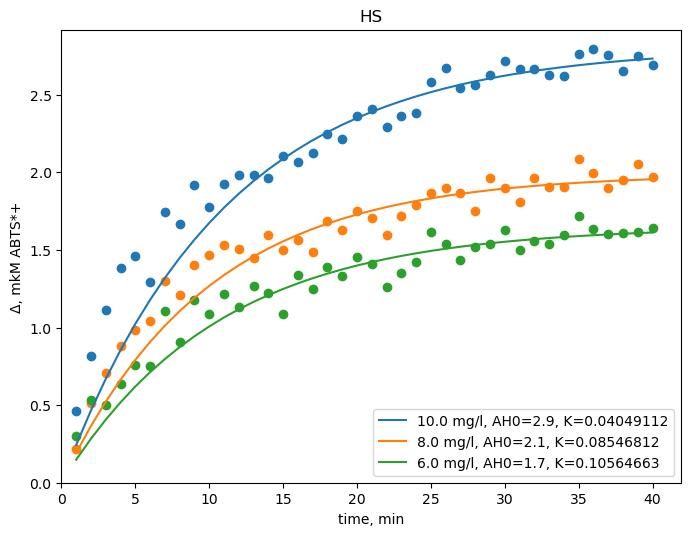

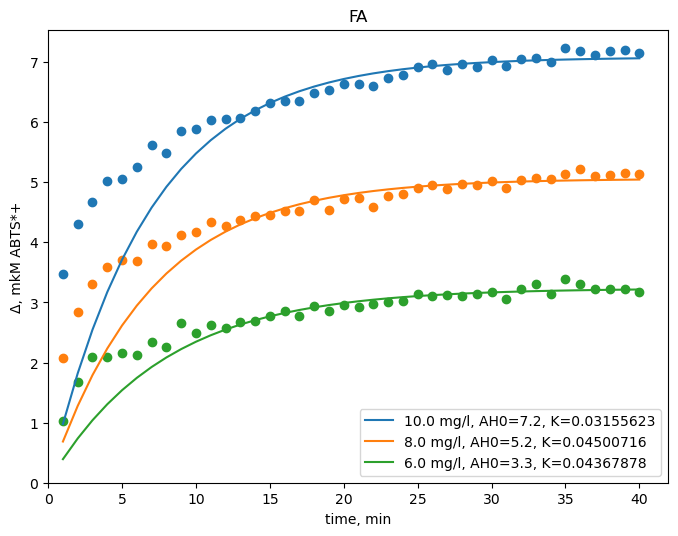

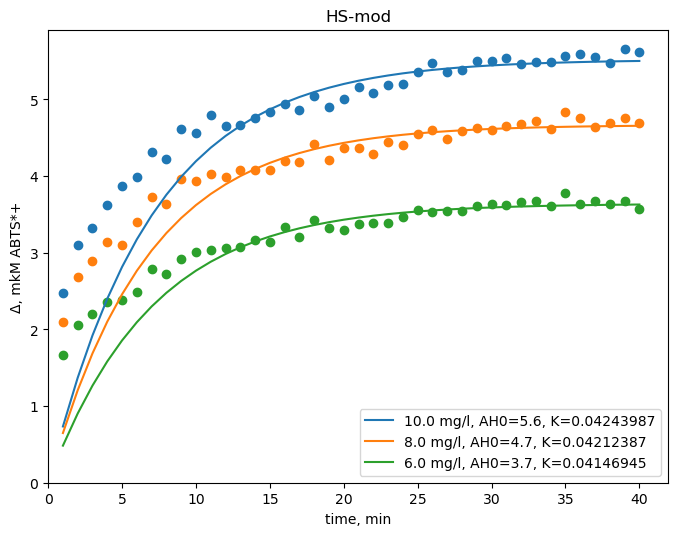

In [9]:
for name in data['name'].unique():
    try:
        calc(name)
    except:
        pass

Посмотрим на посчитанные данные

In [10]:
data_output

,name,conc,AH0,K,k
0,HS,10.0,2.853757,0.040491,0.089232
1,HS,8.0,2.058322,0.085468,0.098093
2,HS,6.0,1.720539,0.105647,0.090345
3,FA,10.0,7.170166,0.031556,0.146708
4,FA,8.0,5.150251,0.045007,0.143039
5,FA,6.0,3.289994,0.043679,0.127078
6,HS-mod,10.0,5.614820,0.042440,0.140250
7,HS-mod,8.0,4.747320,0.042124,0.147061
8,HS-mod,6.0,3.702403,0.041469,0.140231


Рассчитаем антиоксидантную активность по потере радикала АБТС, разделим на концентрацию препарата в растворе

In [11]:
data_output['AOX'] = data_output['AH0'] / data_output['conc']

рассчитаем стандартное отклонение для посчитанной константы и АОХ

In [12]:
std = data_output.groupby('name').std().drop(columns=['conc', 'AH0', 'k'])
std.columns = ['Kstd', 'AOXstd']

рассчитаем среднее и сведём все в одной таблице, сохраним её в файл

In [13]:
mean = data_output.groupby('name').mean().drop(columns=['conc', 'AH0', 'k'])
result = mean.merge(std, on='name')
#result.to_csv(f'{file_name}_result.csv', sep=';')
result

,K,AOX,Kstd,AOXstd
name,,,,
FA,0.040081,0.636377,0.007412,0.084586
HS,0.077202,0.276474,0.033355,0.016628
HS-mod,0.042011,0.590655,0.000495,0.027895
